# Scanning Session Ingestion

## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

Check out the respective elements video: https://www.youtube.com/watch?v=DLYqnj40eAM

Use this as info NB https://github.com/SFB1089/workflow-calcium-imaging/blob/main/notebooks/07-downstream-analysis-optional.ipynb


In [1]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()


[2023-05-08 18:23:54,668][INFO]: Connecting tobiasr@172.26.128.53:3306
[2023-05-08 18:23:54,713][INFO]: Connected tobiasr@172.26.128.53:3306


DataJoint connection (connected) tobiasr@172.26.128.53:3306

Manual entry:

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates relevant schema.

In [2]:
import datajoint as dj
from adamacs.pipeline import subject, session, surgery, scan, event, trial, imaging
from adamacs import utility
from adamacs.ingest import behavior as ibe
from pywavesurfer import ws
import matplotlib.pyplot as plt
# check https://elements.datajoint.org/description/event/ for doc

Assign easy names for relevant tables

In [3]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath())

## Ingesting behavior

In [6]:
ibe.ingest_aux("sess9FHS7Y22","scan9FHS845A", verbose=True)

Number of scans found: 1


/home/tobiasr/miniconda3/envs/datajoint/lib/python3.8/site-packages/pywavesurfer/ws.py:46: RuntimeWarning: You are reading a WaveSurfer file version this module was not tested with: file version 1.0.6, latest version tested: 0.982
  warnings.warn('You are reading a WaveSurfer file version this module was not tested with: '


In [22]:
event.Event()  &  "event_type='HARP_gate'"


session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FHS7Y22,scan9FHS845A,HARP_gate,1.9852,602.413


In [25]:
event.Event()  &  "event_type='shutter'" 


session_id,scan_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
sess9FHS7Y22,scan9FHS845A,shutter,1.7695,2.46435
sess9FHS7Y22,scan9FHS845A,shutter,4.3157,602.398


In [10]:
auxpath = (event.BehaviorRecording.File() & scan_key).fetch('filepath')

In [11]:
curr_file = ws.loadDataFile(filename=auxpath[0], format_string='double' )

/home/tobiasr/miniconda3/envs/datajoint/lib/python3.8/site-packages/pywavesurfer/ws.py:46: RuntimeWarning: You are reading a WaveSurfer file version this module was not tested with: file version 1.0.6, latest version tested: 0.982
  warnings.warn('You are reading a WaveSurfer file version this module was not tested with: '


In [12]:
from adamacs.behavior import demultiplex

ModuleNotFoundError: No module named 'adamacs.behavior'

In [ ]:
import numpy as np

# Plotting analogScans
# plt.figure(figsize=(12, 6))
# plt.title("Analog Scans")

# Creating subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(32, 12))

# Plotting analogScans
axes[0].set_title("Analog Scans - Every 100th Sample")
for i in range(analog_scans.shape[0]):
     axes[i].plot(analog_scans[i][::step], label=f"AI {analog_labels[i]}")
     axes[i].legend()
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")

plt.show()


# Creating subplots
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(32, 12))

# Plotting analogScans
axes[0].set_title("Digital Scans - Every 100th Sample")
for i in range(digital_scans.shape[0]):
     axes[i].plot(digital_scans[i][::step], label=f"DI {digital_labels[i]}")
     axes[i].set_xlabel("Sample Index")
     axes[i].set_ylabel("Signal")
     axes[i].legend()
plt.show()


In [ ]:
main_track_gate_chan = digital_channels[5]
shutter_chan = digital_channels[4]
mini2p_frame_chan = digital_channels[1]
mini2p_line_chan = digital_channels[2]
mini2p_vol_chan = digital_channels[3]
mini2p_IMU_gate = digital_channels[0]

"""Calculate timestamps"""
ts_main_track_gate_chan = ibe.get_timestamps(main_track_gate_chan, sr)
ts_mini2p_IMU_gate = ibe.get_timestamps(mini2p_IMU_gate, sr)
ts_shutter_chan = ibe.get_timestamps(shutter_chan, sr)
ts_mini2p_frame_chan = ibe.get_timestamps(mini2p_frame_chan, sr)
ts_mini2p_line_chan = ibe.get_timestamps(mini2p_line_chan, sr)
ts_mini2p_vol_chan = ibe.get_timestamps(mini2p_vol_chan, sr)

"""Analog signals"""
cam_trigger = curr_file[sweep]['analogScans'][0]
bpod_trial_vis_chan = curr_file[sweep]['analogScans'][1]
bpod_reward1_chan = curr_file[sweep]['analogScans'][2]
bpod_tone_chan = curr_file[sweep]['analogScans'][3]
light_flash_chan = curr_file[sweep]['analogScans'][4]

ts_cam_trigger = ibe.get_timestamps(cam_trigger, sr)
ts_bpod_visual = ibe.get_timestamps(bpod_trial_vis_chan, sr)
ts_bpod_reward = ibe.get_timestamps(bpod_reward1_chan, sr)
ts_bpod_tone = ibe.get_timestamps(bpod_tone_chan, sr)

In [ ]:
print(ts_main_track_gate_chan)
print(ts_mini2p_IMU_gate)
print(len(ts_mini2p_line_chan))
print(len(ts_mini2p_frame_chan))
print(len(ts_mini2p_vol_chan))
print(len(ts_cam_trigger))
print(len(ts_shutter_chan))

In [ ]:
dj.Diagram(subject.Subject) + dj.Diagram(event) + dj.Diagram(scan)

In [ ]:
from pywavesurfer import ws

In [26]:
fp = event.BehaviorRecording.File().fetch('filepath')
print(fp)
curr_file = ws.loadDataFile(filename=fp[0], format_string='double' )


['/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS7Y22_sess9FHS7Y22/scan9FHS7Y22_NK_ROS-1485_2024.h5'
 '/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS845A_sess9FHS7Y22/scan9FHS845A_NK_ROS-1485_2025.h5']


/home/tobiasr/miniconda3/envs/datajoint/lib/python3.8/site-packages/pywavesurfer/ws.py:46: RuntimeWarning: You are reading a WaveSurfer file version this module was not tested with: file version 1.0.6, latest version tested: 0.982
  warnings.warn('You are reading a WaveSurfer file version this module was not tested with: '


In [ ]:
scan.Scan()

In [27]:
fp = event.BehaviorRecording.File().fetch('filepath')
print(fp)

['/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS7Y22_sess9FHS7Y22/scan9FHS7Y22_NK_ROS-1485_2024.h5'
 '/datajoint-data/data/tobiasr/NK_ROS-1485_2023-04-28_scan9FHS845A_sess9FHS7Y22/scan9FHS845A_NK_ROS-1485_2025.h5']


In [28]:
event.AlignmentEvent()

alignment_name,alignment_description,alignment_event_type,alignment_time_shift (s) WRT alignment_event_type,start_event_type,start_time_shift (s) WRT start_event_type,end_event_type,end_time_shift (s) WRT end_event_type


In [29]:
trial.Trial()

session_id,scan_id,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start


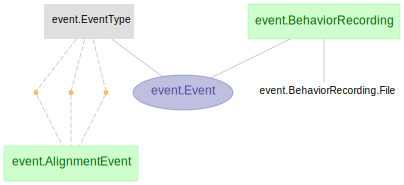

In [30]:
dj.Diagram(event)

In [ ]:
session.Session * session.SessionDirectory

In [ ]:
key='scan9FF6U114'
(scan.Scan & f'scan_id=\"{key}\"')

In [ ]:
scan.Scan()

In [ ]:
scan.ScanInfo.populate()

`CB DEV NOTE:` In demo file, there are no `scan.motor_position_at_zero` values. Set to 0 here to avoid downstream type errors when adding. Future would should set these to null when not present and revise downstream code.

In [ ]:
scan.ScanInfo()

In [ ]:
scan.ScanInfo.Field()

Note the relative path below:

In [ ]:
scan.ScanInfo.ScanFile()